In [1]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.plotting import plot_stat_map, show
from nilearn.plotting import plot_roi, plot_glass_brain
from nilearn.image import clean_img

from function import *

# Loading the Data

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Masking the Data

Shape of the mask:  (91, 109, 91)


C:\Users\User\miniforge3\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


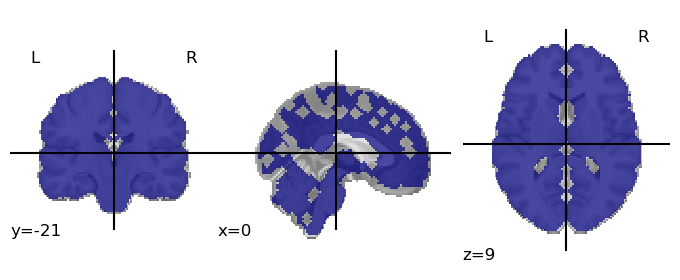

In [4]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

In [5]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


# Labels

In [6]:
random.seed(42)
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))
# train_samples, test_samples, train_labels, test_labels = split(samples, labels, 4)

Numbers of labels/training samples:  1470


In [7]:
num_subs_for_test = 4
num_imgs_per_sub = 30
beta_maps_test = nib.funcs.concat_images(beta_maps[:num_subs_for_test], axis = -1)
beta_maps_train = nib.funcs.concat_images(beta_maps[num_subs_for_test:], axis = -1)
labels_test = labels[:num_imgs_per_sub * num_subs_for_test]
labels_train = labels[num_imgs_per_sub * num_subs_for_test:]

In [8]:
from nilearn.decoding import SpaceNetClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

In [36]:
decoder = SpaceNetClassifier(penalty='tv-l1',
                     mask=mask,
                     max_iter=10, # default is 200
                     cv=5,
                     n_jobs=1,
                     standardize=True,
                     memory="nilearn_cache",
                     memory_level=2,
                     verbose=1)

decoder.fit(beta_maps_train, labels_train)

print(getattr(decoder,'cv_'))
print(getattr(decoder,'cv_scores_'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


Time Elapsed: 118.861 seconds, 1 minutes.
[(array([ 270,  271,  272, ..., 1347, 1348, 1349]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 

In [10]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nSpaceNet Classifier (5fold CV) test accuracy : %g%%" % accuracy)


SpaceNet Classifier (5fold CV) test accuracy : 71.6667%


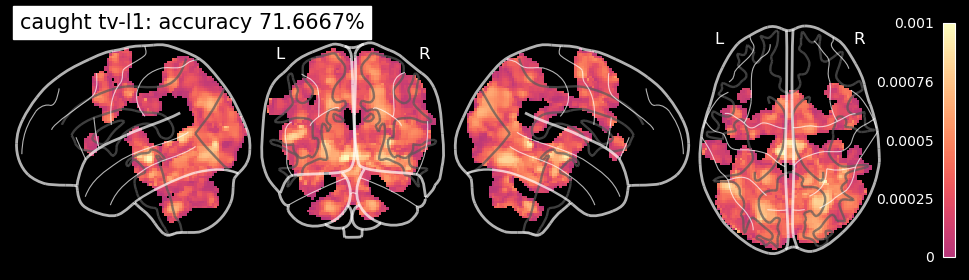

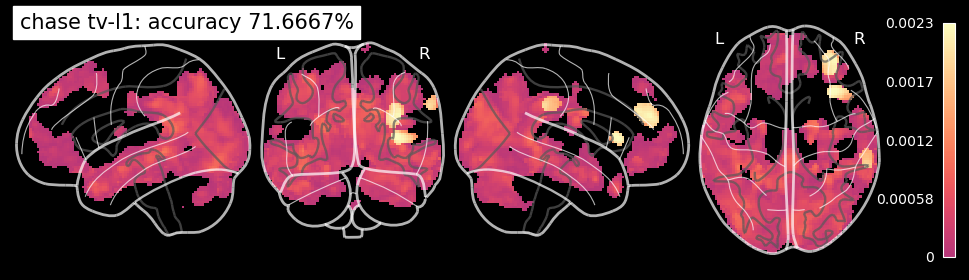

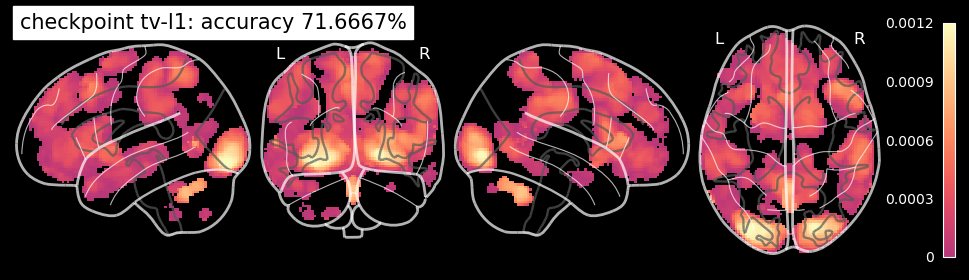

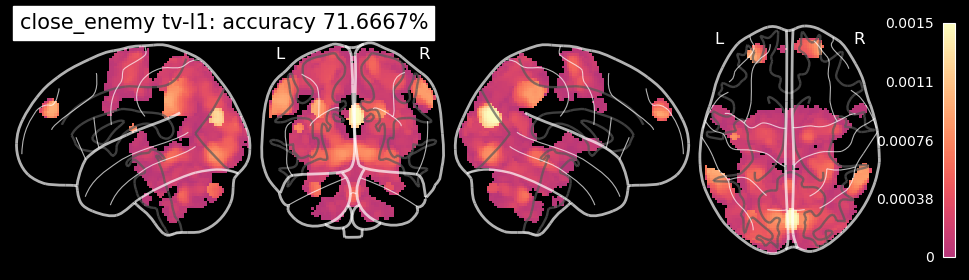

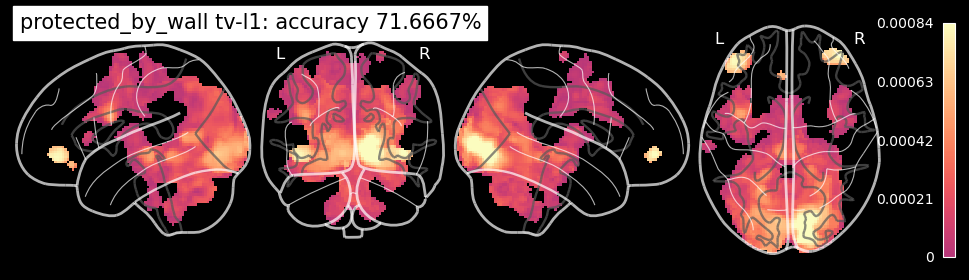

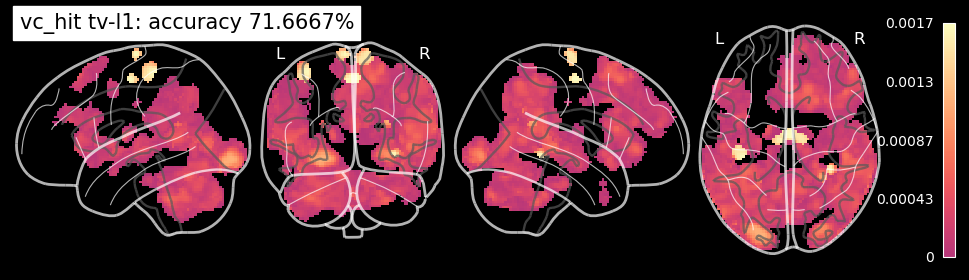

In [11]:
coef_img = decoder.coef_img_

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' tv-l1: accuracy %g%%' % accuracy)